In [1]:
# 1.1 Install if needed (run once)
# !pip install pandas numpy scikit-learn matplotlib seaborn

# 1.2 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor  # or RandomForestClassifier if target is categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score

# For reproducibility
RANDOM_STATE = 42

In [2]:
# 2.1 Parameters for synthetic dataset
n_samples = 5000  # adjust: e.g., 500–2,000 or 2,000–10,000; here's a mid‑size example
np.random.seed(RANDOM_STATE)

# 2.2 Demographic categories
location_zones = ['North', 'South', 'East', 'West', 'Central']
genders = ['Male', 'Female', 'Other']
age_groups = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
income_levels = ['Low', 'Lower-Middle', 'Middle', 'Upper-Middle', 'High']

# 2.3 Generate synthetic demographics
data = pd.DataFrame({
    'Location_zone': np.random.choice(location_zones, size=n_samples, p=[0.2,0.2,0.2,0.2,0.2]),
    'Gender': np.random.choice(genders, size=n_samples, p=[0.48,0.48,0.04]),
    'Age_group': np.random.choice(age_groups, size=n_samples),
    'Income_level': np.random.choice(income_levels, size=n_samples, p=[0.15,0.25,0.30,0.20,0.10]),
})

# 2.4 Generate synthetic sales and profit margin
# Assume sales depend on income level and location slightly, with randomness
base_sales = np.random.normal(loc=100, scale=30, size=n_samples)  # base sales units or revenue
income_multiplier = {'Low': 0.8, 'Lower-Middle': 0.9, 'Middle': 1.0, 'Upper-Middle': 1.1, 'High': 1.2}
zone_multiplier = {'North': 1.0, 'South': 0.95, 'East': 1.05, 'West': 1.0, 'Central': 1.1}

sales = base_sales * np.vectorize(income_multiplier.get)(data['Income_level']) \
                    * np.vectorize(zone_multiplier.get)(data['Location_zone'])
sales = np.maximum(sales, 5)  # avoid negative or tiny

# Profit margin percentage also varies by income level or random
margin_base = np.random.normal(loc=0.2, scale=0.05, size=n_samples)  # 20% avg
margin_adjust = {'Low': -0.02, 'Lower-Middle': -0.01, 'Middle': 0.0, 'Upper-Middle': 0.01, 'High': 0.02}
profit_margin = margin_base + np.vectorize(margin_adjust.get)(data['Income_level'])
profit_margin = np.clip(profit_margin, 0.01, 0.5)  # keep within reasonable bounds

# Add to dataframe
data['Sales'] = sales
data['Profit_margin'] = profit_margin

# Optional: round for readability
data['Sales'] = data['Sales'].round(2)
data['Profit_margin'] = data['Profit_margin'].round(3)

data.head()

,Location_zone,Gender,Age_group,Income_level,Sales,Profit_margin
0,South,Male,65+,Middle,134.13,0.184
1,Central,Male,35-44,Low,84.31,0.217
2,West,Female,18-24,Lower-Middle,88.19,0.248
3,East,Male,45-54,Lower-Middle,97.56,0.194
4,North,Female,55-64,Middle,63.46,0.276


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location_zone  5000 non-null   object 
 1   Gender         5000 non-null   object 
 2   Age_group      5000 non-null   object 
 3   Income_level   5000 non-null   object 
 4   Sales          5000 non-null   float64
 5   Profit_margin  5000 non-null   float64
dtypes: float64(2), object(4)
memory usage: 234.5+ KB
None
       Location_zone Gender Age_group Income_level        Sales  Profit_margin
count           5000   5000      5000         5000  5000.000000    5000.000000
unique             5      3         7            5          NaN            NaN
top            North   Male       65+       Middle          NaN            NaN
freq            1029   2459       768         1522          NaN            NaN
mean             NaN    NaN       NaN          NaN   100.071630       0.199531
std      

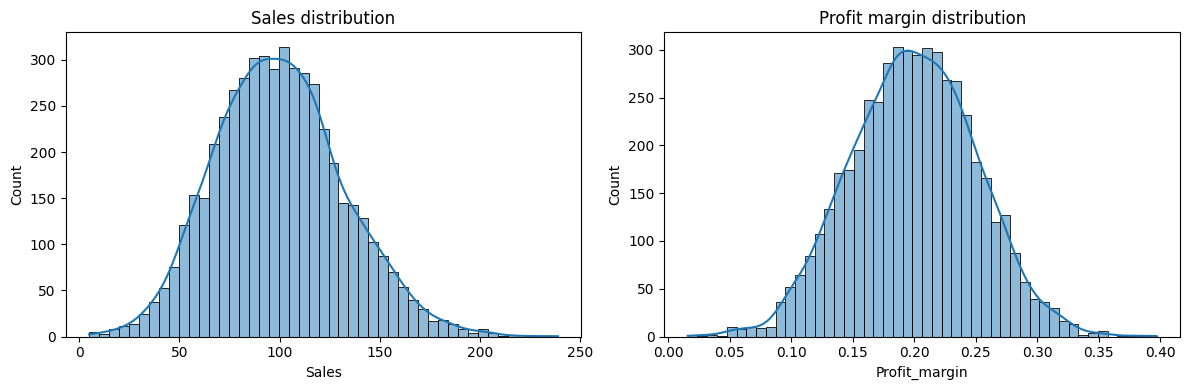

In [3]:
print(data.info())
print(data.describe(include='all'))

# Histograms of numeric
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(data['Sales'], ax=axes[0], kde=True)
axes[0].set_title('Sales distribution')
sns.histplot(data['Profit_margin'], ax=axes[1], kde=True)
axes[1].set_title('Profit margin distribution')
plt.tight_layout()

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_cols = ['Location_zone', 'Gender', 'Age_group', 'Income_level']
numeric_cols = ['Sales']  # plus any other numeric predictors you add

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='drop'
)

In [6]:
X_kmeans = preprocessor.fit_transform(data)
# You can also include profit_margin if clustering on it; for segmentation, maybe keep it for analysis after clustering

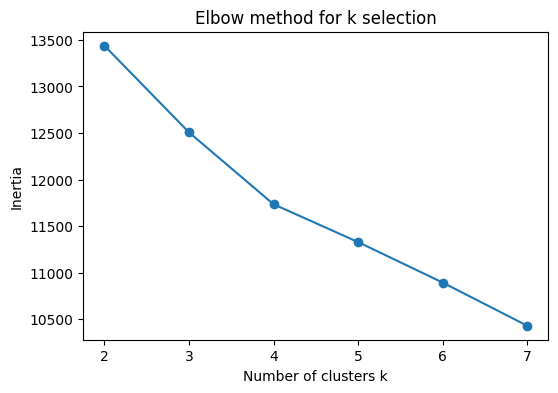

In [7]:
# Try a few cluster counts; for example, 3 to 7
inertias = []
cluster_range = range(2, 8)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    kmeans.fit(X_kmeans)
    inertias.append(kmeans.inertia_)

# Plot inertia to use elbow method
plt.figure(figsize=(6,4))
plt.plot(list(cluster_range), inertias, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow method for k selection')
plt.show()

In [8]:
k_final = 4  # change based on elbow plot
kmeans_final = KMeans(n_clusters=k_final, random_state=RANDOM_STATE, n_init='auto')
clusters = kmeans_final.fit_predict(X_kmeans)
data['Cluster'] = clusters

# Inspect cluster sizes
print(data['Cluster'].value_counts())

# Compare average sales and profit margin per cluster
cluster_stats = data.groupby('Cluster').agg({
    'Sales': ['mean','median'],
    'Profit_margin': ['mean','median'],
    'Location_zone': lambda s: s.mode().iloc[0] if not s.mode().empty else None,
    'Income_level': lambda s: s.mode().iloc[0] if not s.mode().empty else None
})
print(cluster_stats)

Cluster
3    1706
0    1256
2    1046
1     992
Name: count, dtype: int64
              Sales          Profit_margin        Location_zone  Income_level
               mean   median          mean median      <lambda>      <lambda>
Cluster                                                                      
0         63.114212   64.665      0.194017  0.195         South           Low
1        146.668589  142.840      0.210195  0.210       Central  Upper-Middle
2         94.032141   93.070      0.190893  0.192         North  Lower-Middle
3        103.888535  103.625      0.202686  0.203          West        Middle


In [9]:
# Features: demographic cols + Sales (or others)
X = data[categorical_cols + ['Sales']]
y = data['Profit_margin']  # numeric target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [10]:
# Random Forest regressor
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', rf)
])

# Fit
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

Random Forest regresor MSE: 0.002973
R2 score: -0.148


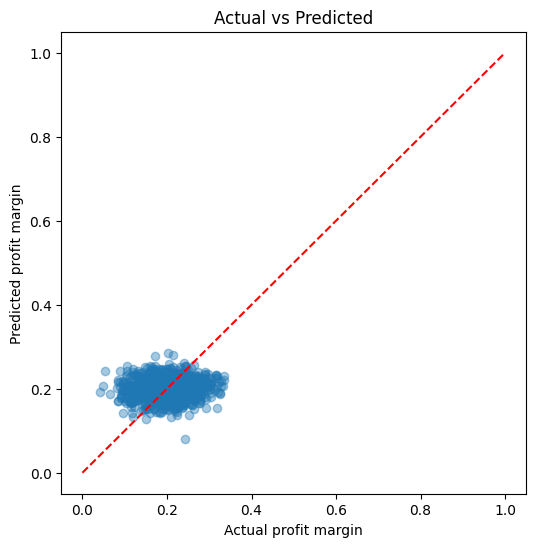

In [11]:
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Random Forest regresor MSE: {mse:.6f}')
print(f'R2 score: {r2:.3f}')

# Compare actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0,1],[0,1], 'r--')
plt.xlabel('Actual profit margin')
plt.ylabel('Predicted profit margin')
plt.title('Actual vs Predicted')
plt.show()

Sales                  0.587677
Gender_Male            0.044345
Location_zone_North    0.034476
Location_zone_West     0.033634
Location_zone_South    0.033281
Location_zone_East     0.031907
Age_group_25-34        0.030505
Age_group_65+          0.028097
Age_group_35-44        0.026739
Age_group_45-54        0.026577
dtype: float64


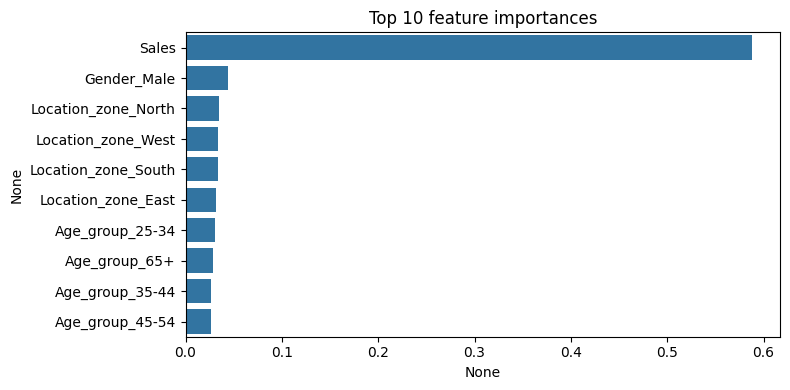

In [12]:
# Get feature names after preprocessing
ohe = pipeline.named_steps['preprocess'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
num_feature_names = numeric_cols
feature_names = list(cat_feature_names) + list(num_feature_names)

importances = pipeline.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print(feat_imp.head(10))

# Plot
plt.figure(figsize=(8,4))
sns.barplot(x=feat_imp.head(10), y=feat_imp.head(10).index)
plt.title('Top 10 feature importances')
plt.tight_layout()
plt.show()

In [13]:
from sklearn.ensemble import RandomForestClassifier

# 7.1 Example: categorize profit margin
bins = [0.0, 0.15, 0.25, 1.0]
labels = ['Low', 'Medium', 'High']
data['Profit_margin_band'] = pd.cut(data['Profit_margin'], bins=bins, labels=labels)

# 7.2 Prepare X, y
X = data[categorical_cols + ['Sales']]
y = data['Profit_margin_band']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Pipeline
rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipeline_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', rf_clf)
])

pipeline_clf.fit(X_train, y_train)

# Evaluate
y_pred = pipeline_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.12      0.09      0.11       159
         Low       0.19      0.20      0.20       175
      Medium       0.65      0.68      0.66       666

    accuracy                           0.50      1000
   macro avg       0.32      0.32      0.32      1000
weighted avg       0.48      0.50      0.49      1000

